### **LIBRERIE**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#**DATASET**

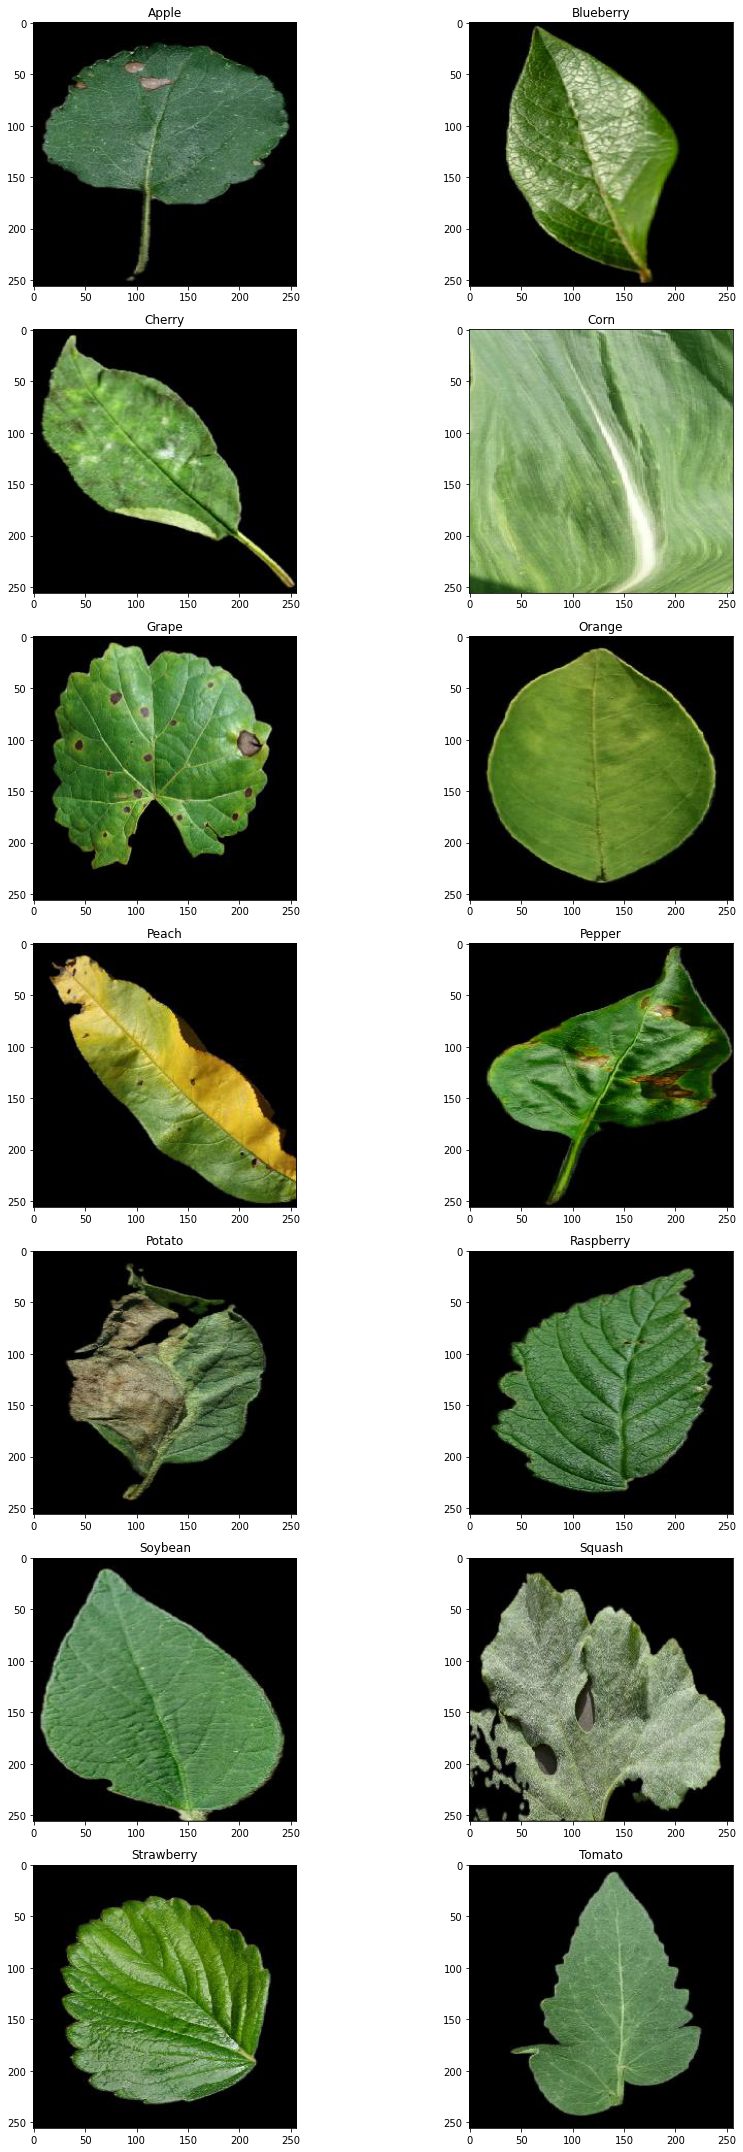

In [ ]:
dataset_dir = '../input/fogliecopypaste/output' 

training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of training images per category:')

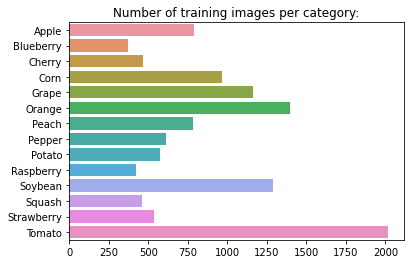

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

###**DATA AUGMENTATION**

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. non worka con vgg16
                                        ) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 11849 images belonging to 14 classes.
Found 2805 images belonging to 14 classes.
Found 13 images belonging to 13 classes.


#**CALLBACKS**

In [ ]:

class RandomSttdev(tf.keras.callbacks.Callback):
    
    def on_epoch_begin(self, epoch, logs=None):
        self.model.layers[2].stddev = random.uniform(0, 0.5)
        print('updating sttdev in training')
        print(self.model.layers[2].stddev)
        
    
    

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('transfer_learning_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)

  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)

  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

# **Transfer learning**

In [ ]:
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')
rand_sttdev = RandomSttdev()

base_model = tfk.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = tfk.Input(shape=(256, 256, 3))
x = tf.keras.layers.Resizing(
    299, 299, interpolation='bilinear', crop_to_aspect_ratio=True,) (inputs)
x = tf.keras.layers.BatchNormalization(axis=1, scale=False)(x)
x = tf.keras.layers.GaussianNoise(0.5)(x)
x = base_model(x, training=False)
x = tfk.layers.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

tl_model = tfk.Model(inputs, output_layer)

tl_model.compile(optimizer=tfk.optimizers.Adam(),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics= 'accuracy')
tl_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 299, 299, 3)       897       
_________________________________________________________________
gaussian_noise (GaussianNois (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
Flattening (Flatten)         (None, 204800)            0         
______________________________________________________________

In [ ]:
# Train the model

tl_history = tl_model.fit(x = aug_train_gen, epochs=200, callbacks=[tl_callbacks,rand_sttdev], validation_data=valid_gen)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200
updating sttdev in training
0.3197133992289419
371/371 [==============================] - 331s 867ms/step - loss: 2.2213 - accuracy: 0.5118 - val_loss: 2.5006 - val_accuracy: 0.4036


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
updating sttdev in training
0.4658780197180387
371/371 [==============================] - 294s 792ms/step - loss: 1.2170 - accuracy: 0.6393 - val_loss: 3.0275 - val_accuracy: 0.4214


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/200
updating sttdev in training
0.1736018826542245
371/371 [==============================] - 297s 799ms/step - loss: 1.0263 - accuracy: 0.6768 - val_loss: 1.9263 - val_accuracy: 0.5105


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/200
updating sttdev in training
0.049855848870989206
371/371 [==============================] - 285s 767ms/step - loss: 0.9404 - accuracy: 0.6972 - val_loss: 1.6917 - val_accuracy: 0.6004


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/200
updating sttdev in training
0.11212243455378279
371/371 [==============================] - 288s 774ms/step - loss: 0.8946 - accuracy: 0.7137 - val_loss: 1.7052 - val_accuracy: 0.5936


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/200
updating sttdev in training
0.46523596356313746
371/371 [==============================] - 286s 771ms/step - loss: 0.8264 - accuracy: 0.7387 - val_loss: 1.5699 - val_accuracy: 0.5865


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/200
updating sttdev in training
0.23323628352031822
371/371 [==============================] - 287s 771ms/step - loss: 0.7919 - accuracy: 0.7495 - val_loss: 1.7466 - val_accuracy: 0.5540


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/200
updating sttdev in training
0.358458983090325
371/371 [==============================] - 290s 780ms/step - loss: 0.7688 - accuracy: 0.7571 - val_loss: 1.5813 - val_accuracy: 0.5872


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/200
updating sttdev in training
0.4844602636007775
371/371 [==============================] - 288s 776ms/step - loss: 0.7289 - accuracy: 0.7699 - val_loss: 1.4185 - val_accuracy: 0.5907


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/200
updating sttdev in training
0.38000206544615417
371/371 [==============================] - 290s 780ms/step - loss: 0.7163 - accuracy: 0.7802 - val_loss: 1.1432 - val_accuracy: 0.6895


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/200
updating sttdev in training
0.4330161149885761
371/371 [==============================] - 293s 788ms/step - loss: 0.6826 - accuracy: 0.7891 - val_loss: 1.1105 - val_accuracy: 0.6852


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/200
updating sttdev in training
0.2735231293061157
371/371 [==============================] - 292s 786ms/step - loss: 0.6827 - accuracy: 0.7855 - val_loss: 1.3057 - val_accuracy: 0.6538


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/200
updating sttdev in training
0.2352682838353401
371/371 [==============================] - 291s 784ms/step - loss: 0.6616 - accuracy: 0.7942 - val_loss: 1.0639 - val_accuracy: 0.7169


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/200
updating sttdev in training
0.3292283475001013
371/371 [==============================] - 297s 800ms/step - loss: 0.6598 - accuracy: 0.7968 - val_loss: 1.2710 - val_accuracy: 0.6403


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/200
updating sttdev in training
0.17937080105679837
371/371 [==============================] - 291s 782ms/step - loss: 0.6500 - accuracy: 0.7988 - val_loss: 1.0591 - val_accuracy: 0.7066


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/200
updating sttdev in training
0.2793153564348294
371/371 [==============================] - 291s 785ms/step - loss: 0.6449 - accuracy: 0.8053 - val_loss: 1.1131 - val_accuracy: 0.6991


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/200
updating sttdev in training
0.009697698623498174
371/371 [==============================] - 291s 783ms/step - loss: 0.6253 - accuracy: 0.8077 - val_loss: 1.2419 - val_accuracy: 0.6756


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/200
updating sttdev in training
0.3869125682781283
371/371 [==============================] - 293s 788ms/step - loss: 0.6389 - accuracy: 0.8029 - val_loss: 1.2067 - val_accuracy: 0.6848


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/200
updating sttdev in training
0.11893917700973838
371/371 [==============================] - 298s 801ms/step - loss: 0.6089 - accuracy: 0.8142 - val_loss: 1.0976 - val_accuracy: 0.6991


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/200
updating sttdev in training
0.3696835224735113
371/371 [==============================] - 293s 788ms/step - loss: 0.6167 - accuracy: 0.8135 - val_loss: 1.3591 - val_accuracy: 0.6592


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/200
updating sttdev in training
0.2703160783972864
371/371 [==============================] - 305s 822ms/step - loss: 0.6156 - accuracy: 0.8057 - val_loss: 1.1548 - val_accuracy: 0.6706


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/200
updating sttdev in training
0.48821038922235666
371/371 [==============================] - 301s 811ms/step - loss: 0.5857 - accuracy: 0.8191 - val_loss: 1.3528 - val_accuracy: 0.6745


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/200
updating sttdev in training
0.04791670491702971
371/371 [==============================] - 303s 815ms/step - loss: 0.5986 - accuracy: 0.8180 - val_loss: 1.4371 - val_accuracy: 0.6528


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Plot the training

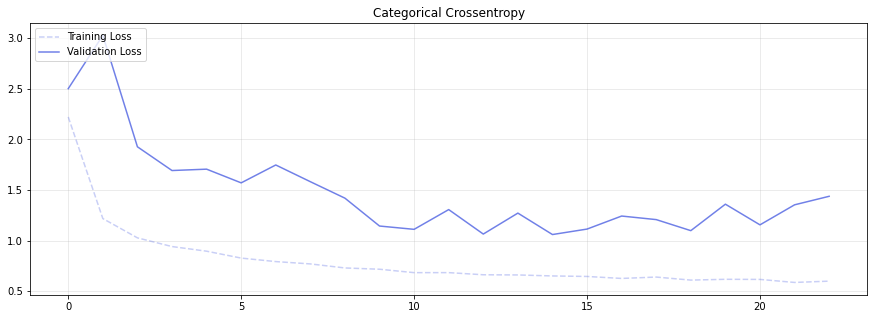

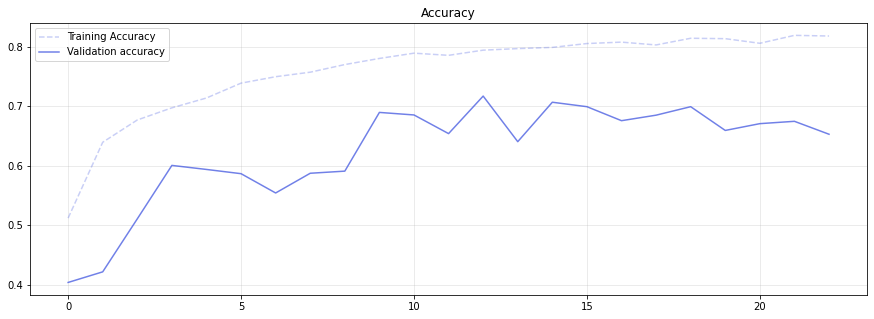

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(tl_history.history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history.history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

#**Training stopped due to the low accuracy**

# Save the best model

In [ ]:
tl_model.save('DadoDato.h5')
#del tl_model  # To avoid filling the memory



>TEST



In [ ]:
tl_model = tfk.models.load_model('../input/dadodato/DadoDato.h5')

In [ ]:
# Trained with data augmentation
test_model = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(test_model)

## **FINE TUNING**

In [ ]:
# Re-load the model after transfer learning
ft_model = tl_model#tfk.models.load_model('DadoDato.h5')
ft_model.summary()
# Set all VGG layers to True
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers
for i, layer in enumerate(ft_model.get_layer('xception').layers[:125]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10,verbose= 2 , restore_best_weights=True)]
).history

In [ ]:
#Save the best model
ft_model.save('EchiLoSa.h5')
#del tl_model  # To avoid filling the memory



In [ ]:
# Trained with data augmentation
FT_test = ft_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(FT_test)

In [ ]:
print(f"val_acc:{max(ft_history['val_accuracy'])} val_loss: {min(ft_history['val_loss'])}")
print(f"train_acc:{max(ft_history['accuracy'])} train_loss: {min(ft_history['loss'])}")